## Problem Statement

This notebook will explore using GAN to transfer Monet style art onto other photos.

#### Data Description

We are given about 300 Monet Style Photos, all 256x256 RGB channel for our input of the Monet Photos. As well we are given about 7,000 regular photos, also 256x256 RGB, and these images are to converted into Monet Style photos.

# Packages

In [29]:
import glob
from functools import partial
import os
import PIL
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, \
    LeakyReLU, Dropout, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.utils import plot_model

import tensorflow_addons as tfa
from tensorflow_addons.layers import InstanceNormalization

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

In [5]:
# GLOBAL VARIALBES
MONET_PATH = r'/kaggle/input/gan-getting-started/monet_tfrec'
PHOTO_PATH = r'/kaggle/input/gan-getting-started/photo_tfrec'

MONET_FILENAMES = glob.glob(MONET_PATH + '/*.tfrec')
PHOTO_FILENAMES = glob.glob(PHOTO_PATH + '/*.tfrec')

AUTOTUNE = tf.data.AUTOTUNE
IMAGE_SIZE = (256,256,3)
BATCH_SIZE = 1
OUTPUT_CHANNEL = 3

# Data Description

In [6]:
# Functions to read and process TFRecord data
def _parse_image(example):
    features = {
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.string),        
    }
    example = tf.io.parse_single_example(example, features)
    
    # Get the converted image 
    target = example['target']
    
    image_name = example['image_name']
    
    image = example['image']
    image = tf.image.decode_jpeg(image,channels=3)
    image = (tf.cast(image, tf.float32)/127.5) - 1  
    image = tf.reshape(image, [*IMAGE_SIZE])
    
    return image #, image_name
    
def read_tfrecord(filenames): 
    
    # Read the TF Record
    tfrecord = tf.data.TFRecordDataset(filenames)
    
    # Options to increase speed as orddering does not matter
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False 
    tfrecord = tfrecord.with_options(ignore_order)
    
    # Map the record to the images
    tfrecord = tfrecord.map(partial(_parse_image),num_parallel_calls=AUTOTUNE)
    
    tfrecord.shuffle(2048)
    tfrecord.prefetch(AUTOTUNE)
    
    return tfrecord.batch(BATCH_SIZE)

def display_grid(data_iter,dim=(3,3),title=None):
    fig,axs = plt.subplots(dim[0],dim[1],figsize=(dim[0]*2.5,dim[1]*2.5))
    axs[0,0].set_title(title,loc='left')
    for i in range(dim[0]):
        for j in range(dim[1]):
            img = next(data_iter)
            img = tf.reshape(img,IMAGE_SIZE)
            axs[i,j].imshow(img*0.5+0.5)
            axs[i,j].axis('off')

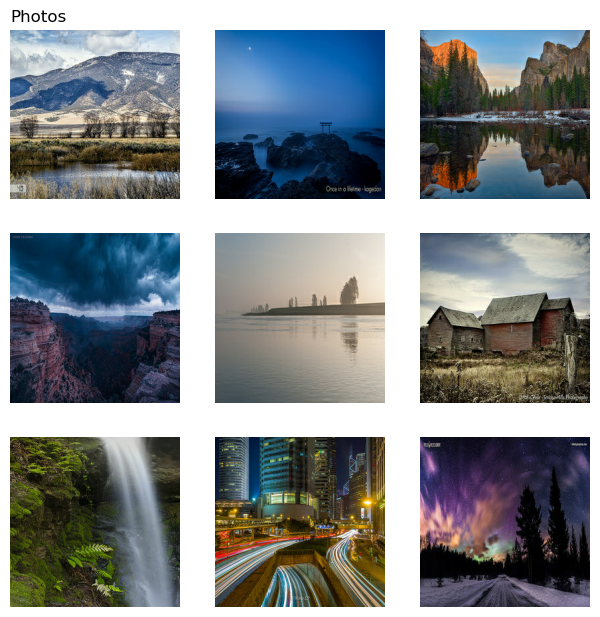

In [7]:
# Visualize a few images
# Regular Photos
photo_iter = iter(read_tfrecord(PHOTO_FILENAMES))
display_grid(photo_iter,title='Photos')

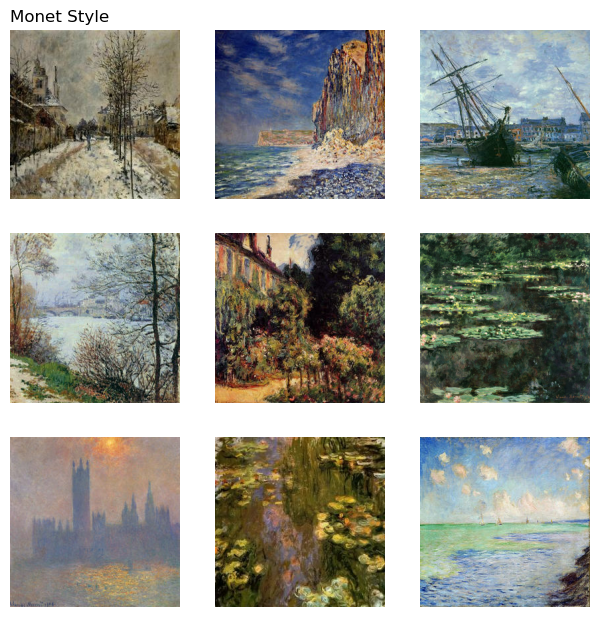

In [8]:
# Monet Style Photos 
monet_iter = iter(read_tfrecord(MONET_FILENAMES))
display_grid(monet_iter,title='Monet Style')

# Model Architecture

The model architecture we are going to be using for this is CycleGAN. CycleGAN works by joining two generators and two discriminator together and cycles from image A to B with generator 1 and discriminator 1 and the B back to A with generator and discriminator 2. Advantages of this is that we do not need paired images, and the model learns to transfer a style to a new image. As well, with this model we will be including a resnet inside the generator. This will help create skip connections in the model helping prevent exploding/vanishing gradient as well as overfitting.



In [9]:
# Loss Functions
LAMBDA = 10
def generator_loss(img_0, img_1):
    return BinaryCrossentropy(from_logits=True)(img_0,img_1)
def discriminator_loss(real_img, gen_img):
    real_loss = generator_loss(real_img)
    gen_loss = generator_loss(gen_img)
    return (real_loss + gen_loss)/2
def cycle_loss(real_img, cycled_img): 
    return tf.reduce_mean(tf.abs(real_img-cycled_img)) * LAMBDA
def identity_loss(real_img, gen_real_img):
    return LAMBDA * 0.5 * tf.reduce_mean(tf.abs(real_image - gen_real_img))

In [10]:
def build_generator(input_shape, output_channels):
    init = RandomNormal(stddev=0.02,seed=1002)
    gamma_init = RandomNormal(stddev=0.02,seed=1002)
    
    inputs = Input(shape=input_shape)

    # Encoder
    enc1 = Conv2D(64, 3, strides=(2, 2), padding='same', kernel_initializer=init)(inputs)
    enc1 = LeakyReLU(alpha=0.2)(enc1)

    enc2 = Conv2D(128, 3, strides=(2, 2), padding='same', kernel_initializer=init)(enc1)
    enc2 = InstanceNormalization()(enc2)
    enc2 = LeakyReLU(alpha=0.2)(enc2)

    enc3 = Conv2D(256, 3, strides=(2, 2), padding='same', kernel_initializer=init)(enc2)
    enc3 = InstanceNormalization()(enc3)
    enc3 = LeakyReLU(alpha=0.2)(enc3)
    
    # Add Resnets?

    # Decoder
    dec1 = Conv2DTranspose(128, 3, strides=(2, 2), padding='same', kernel_initializer=init)(enc3)
    dec1 = InstanceNormalization()(dec1)
    dec1 = tf.nn.relu(dec1)

    dec2 = Conv2DTranspose(64, 3, strides=(2, 2), padding='same', kernel_initializer=init)(dec1)
    dec2 = InstanceNormalization()(dec2)
    dec2 = tf.nn.relu(dec2)
    
    dec3 = Conv2DTranspose(128, 3, strides=(2, 2), padding='same', kernel_initializer=init)(dec2)
    dec3 = InstanceNormalization()(dec3)
    dec3 = tf.nn.relu(dec3)    

    outputs = Conv2DTranspose(output_channels, 3, strides=(1, 1), padding='same', activation='tanh', kernel_initializer=init)(dec3)

    return Model(inputs, outputs)

# plot_model(build_generator(IMAGE_SIZE,OUTPUT_CHANNEL))

In [11]:
def build_discriminator(input_shape):
    init = RandomNormal(stddev=0.02,seed=1002)
    gamma_init = RandomNormal(stddev=0.02,seed=1002)
    
    inputs = Input(shape=input_shape)

    dec1 = Conv2D(64, 3, strides=(2, 2), padding='same', kernel_initializer=init)(inputs)
    dec1 = LeakyReLU(alpha=0.3)(dec1)

    dec2 = Conv2D(128, 3, strides=(2, 2), padding='same', kernel_initializer=init)(dec1)
    dec2 = InstanceNormalization()(dec2)
    dec2 = LeakyReLU(alpha=0.3)(dec2)

    dec3 = Conv2D(256, 3, strides=(2, 2), padding='same', kernel_initializer=init)(dec2)
    dec3 = InstanceNormalization()(dec3)
    dec3 = LeakyReLU(alpha=0.3)(dec3)

    outputs = Conv2D(1, (4, 4), strides=(1, 1), padding='same', kernel_initializer=init)(dec3)

    return Model(inputs, outputs)

# plot_model(build_discriminator(IMAGE_SIZE))

In [50]:
# Define the CycleGAN model
class CycleGAN(tf.keras.Model):
    def __init__(self, input_shape, output_channels, lambda_cycle=10,learning_rate=2e-4):
        super(CycleGAN, self).__init__()
        self.lambda_cycle = lambda_cycle

        self.G_AB = build_generator(input_shape, output_channels)
        self.G_BA = build_generator(input_shape, output_channels)
        self.D_A = build_discriminator(input_shape)
        self.D_B = build_discriminator(input_shape)

        self.generator_loss = generator_loss
        self.cycle_loss = cycle_loss
        self.identity_loss = identity_loss

        self.learning_rate = learning_rate
        
        self.optimizer_G = SGD(learning_rate=self.learning_rate)
        self.optimizer_D = SGD(learning_rate=self.learning_rate)

    def compile(self):
        super(CycleGAN, self).compile()
        self.G_AB.compile(optimizer=self.optimizer_G, loss=self.generator_loss,metrics=self.identity_loss)
        self.G_BA.compile(optimizer=self.optimizer_G, loss=self.generator_loss,metrics=self.identity_loss)
        self.D_A.compile(optimizer=self.optimizer_D, loss=self.generator_loss,metrics=self.identity_loss)
        self.D_B.compile(optimizer=self.optimizer_D, loss=self.generator_loss,metrics=self.identity_loss)

    def forward(self, real_A, real_B):
        fake_B = self.G_AB(real_A)
        fake_A = self.G_BA(real_B)

        rec_A = self.G_BA(fake_B)
        rec_B = self.G_AB(fake_A)

        return fake_A, fake_B, rec_A, rec_B

    def train_step(self, batch_data):
        real_A, real_B = batch_data

        with tf.GradientTape(persistent=True) as tape:
            fake_A, fake_B, rec_A, rec_B = self.forward(real_A, real_B)

            # Adversarial loss
            pred_real_A = self.D_A(real_A)
            loss_D_A_real = self.generator_loss(pred_real_A, tf.ones_like(pred_real_A))
            pred_fake_A = self.D_A(fake_A)
            loss_D_A_fake = self.generator_loss(pred_fake_A, tf.zeros_like(pred_fake_A))
            loss_D_A = 0.5 * (loss_D_A_real + loss_D_A_fake)

            pred_real_B = self.D_B(real_B)
            loss_D_B_real = self.generator_loss(pred_real_B, tf.ones_like(pred_real_B))
            pred_fake_B = self.D_B(fake_B)
            loss_D_B_fake = self.generator_loss(pred_fake_B, tf.zeros_like(pred_fake_B))
            loss_D_B = 0.5 * (loss_D_B_real + loss_D_B_fake)

            loss_D = loss_D_A + loss_D_B

            # Generator adversarial loss
            loss_G_AB = self.generator_loss(pred_fake_A, tf.ones_like(pred_fake_A))
            loss_G_BA = self.generator_loss(pred_fake_B, tf.ones_like(pred_fake_B))

            # Cycle consistency loss
            loss_cycle_A = self.cycle_loss(real_A, rec_A)
            loss_cycle_B = self.cycle_loss(real_B, rec_B)

            loss_cycle = self.lambda_cycle * (loss_cycle_A + loss_cycle_B)

            loss_G = loss_G_AB + loss_G_BA + loss_cycle

        # Update generators
        grads_G = tape.gradient(loss_G, self.G_AB.trainable_variables + self.G_BA.trainable_variables)
        self.optimizer_G.apply_gradients(zip(grads_G, self.G_AB.trainable_variables + self.G_BA.trainable_variables))

        # Update discriminators
        grads_D_A = tape.gradient(loss_D_A, self.D_A.trainable_variables)
        self.optimizer_D.apply_gradients(zip(grads_D_A, self.D_A.trainable_variables))

        grads_D_B = tape.gradient(loss_D_B, self.D_B.trainable_variables)
        self.optimizer_D.apply_gradients(zip(grads_D_B, self.D_B.trainable_variables))

        del tape

        return {
            "loss_D_A": loss_D_A,
            "loss_D_B": loss_D_B,
            "loss_G_AB": loss_G_AB,
            "loss_G_BA": loss_G_BA,
            "loss_cycle": loss_cycle,
        }

In [15]:
# Training Data
monet_data = read_tfrecord(MONET_FILENAMES)
photo_data = read_tfrecord(PHOTO_FILENAMES)

MAX_EPOCH = 10

# Create all the models
monet_generator = build_generator(IMAGE_SIZE,OUTPUT_CHANNEL)
photo_generator = build_generator(IMAGE_SIZE,OUTPUT_CHANNEL)
monet_discriminator = build_discriminator(IMAGE_SIZE)
photo_discriminator = build_discriminator(IMAGE_SIZE)

model_gan = CycleGAN(
    input_shape = IMAGE_SIZE,
    output_channels = OUTPUT_CHANNEL
)

In [16]:
# Training Data
model_gan.compile()
with tf.device('/GPU:0'):
    history = model_gan.fit(tf.data.Dataset.zip((monet_data,photo_data)),epochs=MAX_EPOCH)

Epoch 1/10
300/300 [==============================] - 37s 68ms/step - loss_D_A: -0.8689 - loss_D_B: -0.8910 - loss_G_AB: -2.4535 - loss_G_BA: -2.4531 - loss_cycle: 64.4715
Epoch 2/10
300/300 [==============================] - 20s 67ms/step - loss_D_A: -5.2004 - loss_D_B: -5.3085 - loss_G_AB: -11.1681 - loss_G_BA: -11.1374 - loss_cycle: 54.2056
Epoch 3/10
300/300 [==============================] - 20s 66ms/step - loss_D_A: -9.9760 - loss_D_B: -10.2213 - loss_G_AB: -21.1736 - loss_G_BA: -21.3193 - loss_cycle: 49.1129
Epoch 4/10
300/300 [==============================] - 20s 67ms/step - loss_D_A: -15.2226 - loss_D_B: -15.5824 - loss_G_AB: -32.9832 - loss_G_BA: -32.9857 - loss_cycle: 46.2797
Epoch 5/10
300/300 [==============================] - 20s 67ms/step - loss_D_A: -21.0161 - loss_D_B: -21.4832 - loss_G_AB: -46.1612 - loss_G_BA: -46.2454 - loss_cycle: 44.1714
Epoch 6/10
300/300 [==============================] - 20s 66ms/step - loss_D_A: -27.5195 - loss_D_B: -28.0841 - loss_G_AB: -60.

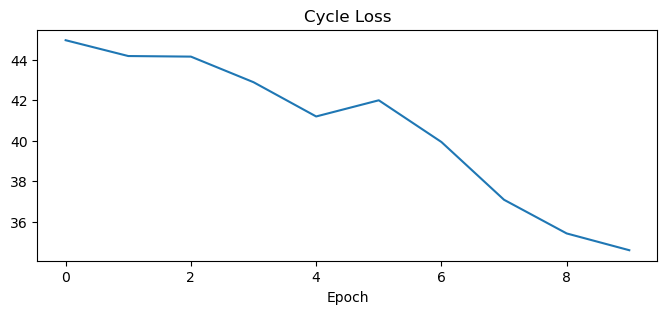

In [51]:
def plot_diagnostic(history,name,title):
    fig = plt.figure(figsize=(8,3))
    ax = plt.gca()
    
    plt.title(title)
    plt.plot(range(len(history.history[name])),history.history[name])
    plt.xlabel('Epoch')
    plt.show();
    
plot_diagnostic(history,'loss_cycle','Cycle Loss')

From the above image we see that the cycle loss appears to continue to decline. This indicates we can likely continue to run a larger number of epochs until we see convergence. Also notice the slight uptick in loss after the fourth Epoch, this can indicate that the learning rate may be too high, but given it is very slight it likely is not a learning rate issue.

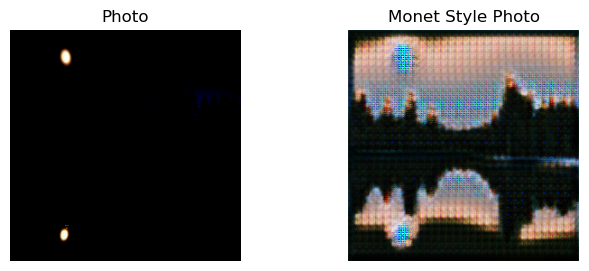

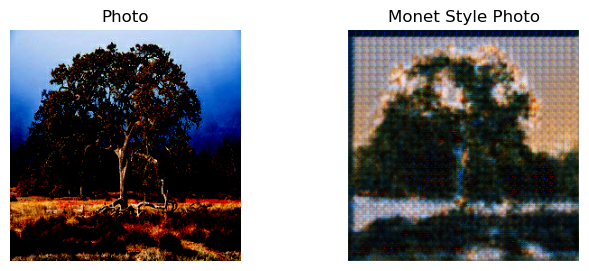

In [48]:
def display_result(image, monet_image):
    fig,axs = plt.subplots(1,2,figsize=(8,3))
    
    axs[0].imshow(image)
    axs[0].axis('off')
    axs[0].set_title('Photo')
    
    axs[1].imshow(monet_image)
    axs[1].axis('off')
    axs[1].set_title('Monet Style Photo')

img = next(photo_iter)
prediction = model_gan.G_AB(img,training=False)[0].numpy()
prediction = (prediction*127.5+127.5).astype(np.uint8)
img = tf.reshape(img,IMAGE_SIZE)
display_result(img,prediction)

img = next(photo_iter)
prediction = model_gan.G_AB(img,training=False)[0].numpy()
prediction = (prediction*127.5+127.5).astype(np.uint8)
img = tf.reshape(img,IMAGE_SIZE)
display_result(img,prediction)

The current monet style transfer is not too bad for a first iteration, but notice there are block like images in the monet transfer. Next we will try increasing the Epochs to see if this improves the images at all.

In [52]:
# Training Data
with tf.device('/GPU:0'):
    history = model_gan.fit(tf.data.Dataset.zip((monet_data,photo_data)),epochs=MAX_EPOCH*2)

Epoch 1/20
300/300 [==============================] - 20s 67ms/step - loss_D_A: -77.8179 - loss_D_B: -79.6175 - loss_G_AB: -168.5855 - loss_G_BA: -173.5814 - loss_cycle: 36.8577
Epoch 2/20
300/300 [==============================] - 20s 67ms/step - loss_D_A: -93.8713 - loss_D_B: -96.1832 - loss_G_AB: -201.9135 - loss_G_BA: -208.5585 - loss_cycle: 37.2337
Epoch 3/20
300/300 [==============================] - 20s 67ms/step - loss_D_A: -113.2846 - loss_D_B: -116.0982 - loss_G_AB: -241.9311 - loss_G_BA: -250.5476 - loss_cycle: 35.9324
Epoch 4/20
300/300 [==============================] - 20s 67ms/step - loss_D_A: -136.9196 - loss_D_B: -140.2653 - loss_G_AB: -290.7608 - loss_G_BA: -303.4747 - loss_cycle: 36.5866
Epoch 5/20
300/300 [==============================] - 20s 66ms/step - loss_D_A: -165.9295 - loss_D_B: -169.9165 - loss_G_AB: -354.6581 - loss_G_BA: -370.5257 - loss_cycle: 37.4784
Epoch 6/20
300/300 [==============================] - 20s 67ms/step - loss_D_A: -201.5912 - loss_D_B: -2

From the above losses, we can see the cycle loss appear to have converged hovering around 34, so likely we needed to increase the epoch only slightly more to about 13.

Let's reevaluate if it improved the image at all

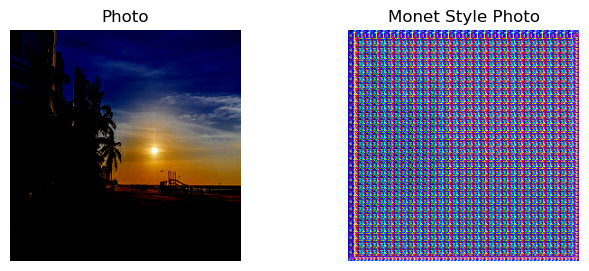

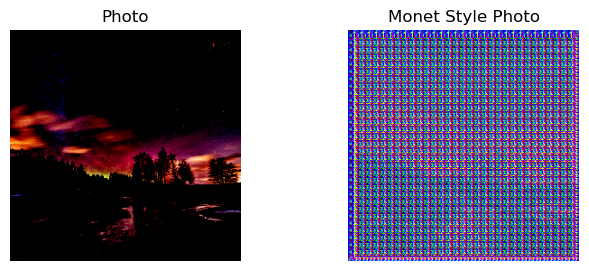

In [55]:
img = next(photo_iter)
prediction = model_gan.G_AB(img,training=False)[0].numpy()
prediction = (prediction*127.5+127.5).astype(np.uint8)
img = tf.reshape(img,IMAGE_SIZE)
display_result(img,prediction)

img = next(photo_iter)
prediction = model_gan.G_AB(img,training=False)[0].numpy()
prediction = (prediction*127.5+127.5).astype(np.uint8)
img = tf.reshape(img,IMAGE_SIZE)
display_result(img,prediction)

Interestingly the model is picking up block like images from the style transfer. We are likely at this point overfitting our model and would have to revert to the old image.

In [27]:
# Create the submission file - On initial model
if not os.path.exists('/kaggle/tmp'):
    os.mkdir('/kaggle/tmp')

i = 1
with tf.device('/GPU:0'):
    for img in photo_data:
        prediction = model_gan.G_AB(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        im = PIL.Image.fromarray(prediction)
        im.save("/kaggle/tmp/" + str(i) + ".jpg")
        i += 1
    
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/tmp")


'/kaggle/working/images.zip'

# Results and Analysis

Only iterating once without tuning the hyper parameters had fairly strong performance advocating the strong use case for Cycle GAN in this situation. The initial learning rate chosen showed decent performance as our cycle loss continued for the most part on a downward trend. After increasing the Epoch though, we started to notice the model started to overfit the data creating block like styles not seen in the Monet Style. 

# Conclusion

Our final model came back with a MiFID score of 189. This indicates that there are still much more room for improvements needed.

In future models, we will explore controlling the overfitting of the model as evident by the style like blocks such as early stopping. As well changing the architecture of the model could likely help with the overfitting as well, whether that be simplifying the model by reducing layers or adding regularizer or even some dropout layers. 

# References
* https://blog.tensorflow.org/2018/08/neural-style-transfer-creating-art-with-deep-learning.html
* https://www.tensorflow.org/tutorials/generative/cyclegan
* https://arxiv.org/pdf/1703.10593.pdf